# Model Training

In [15]:
%load_ext autoreload
%autoreload 2

import common
import pandas as pd
import scipy.sparse
import joblib
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import wandb
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nontaphat-c (nontaphat-c-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
def evaluate(y_true,y_pred,digits=5):
    print(classification_report(y_true,y_pred,digits=digits))
    confusion_mtx = confusion_matrix(y_true,y_pred)
    disp = ConfusionMatrixDisplay(confusion_mtx)
    disp.plot()
    plt.show()

## Parameters

In [5]:
# change this accordingly
project_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

save_path = f"{project_path}/scicite_preprocessed"
dataset = "selected-features"
project_name = "model-comparison-smote-random-forest-fine-tuned"

## 1. Load dataset

In [6]:
train_df = pd.read_csv(f"{save_path}/train-{dataset}.csv")
test_df = pd.read_csv(f"{save_path}/test-{dataset}.csv")
label_encoder = joblib.load(f"{save_path}/label_encoder.pkl")

X_train = train_df.drop(columns=['label'])
y_train = train_df["label"]
X_test = test_df.drop(columns=['label'])
y_test = test_df["label"]

smote = SMOTE(sampling_strategy='all', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## 2. Train-validation split

In [7]:
# Split into 80% train and 20% validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4. Train Random Forest Classifier

Random Forest Classifier based line
-----Evaluation-----
Accuracy: 0.8175
Macro F1-score: 0.7949
Micro F1-score: 0.8175


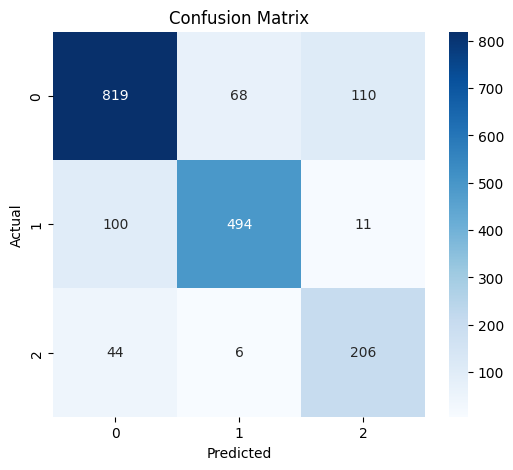

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy Score,▁
Macro F1-score,▁
Micro F1-score,▁
Accuracy Score,0.81755
Macro F1-score,0.7949
Micro F1-score,0.81755


In [8]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

wandb.init(project=f"{project_name}-{dataset}", name="random-forest-classifier-base-line")
common.evaluate(y_test, y_pred_rf, label_encoder, "Random Forest Classifier based line")
wandb.finish()

              precision    recall  f1-score   support

           0    0.85047   0.82146   0.83571       997
           1    0.86972   0.81653   0.84228       605
           2    0.62997   0.80469   0.70669       256

    accuracy                        0.81755      1858
   macro avg    0.78339   0.81423   0.79490      1858
weighted avg    0.82636   0.81755   0.82008      1858



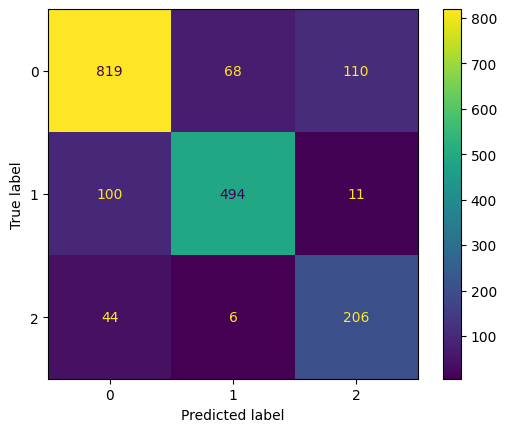

In [ ]:
# fined-tuned
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate(y_test,y_pred_rf)

In [ ]:
params = {"n_estimators":[100,500,1000],"criterion":['gini','entropy'],"n_jobs":[-1],'class_weight':['balanced','balanced_subsample'],'bootstrap':[False,True],"max_features":['log2','sqrt'],"n_jobs":[-1]}

              precision    recall  f1-score   support

           0    0.85047   0.82146   0.83571       997
           1    0.86972   0.81653   0.84228       605
           2    0.62997   0.80469   0.70669       256

    accuracy                        0.81755      1858
   macro avg    0.78339   0.81423   0.79490      1858
weighted avg    0.82636   0.81755   0.82008      1858



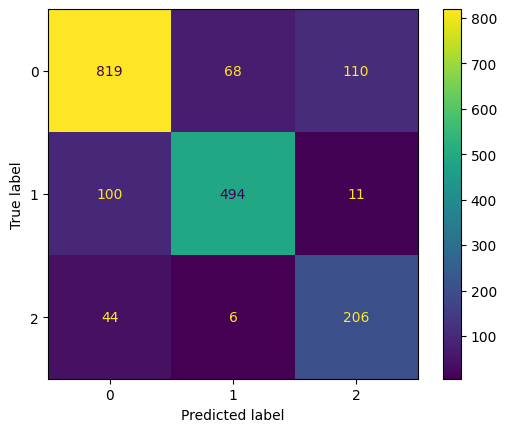

In [18]:
model = GridSearchCV(rf_model,params)
model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
evaluate(y_test,y_pred)

In [20]:
model.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'n_estimators': 1000,
 'n_jobs': -1}

In [ ]:
model.cv_results_

{'mean_fit_time': array([ 3.74838028, 37.11943932, 45.55374932,  3.1403358 , 10.80148039,
        31.45782409]),
 'std_fit_time': array([ 0.35533615, 31.45119191, 43.03028302,  0.09663012,  0.53205689,
        22.26314881]),
 'mean_score_time': array([0.27358451, 1.09865165, 0.98737245, 0.29785457, 0.49144115,
        1.10685277]),
 'std_score_time': array([0.02941891, 0.58692793, 0.32158568, 0.08811357, 0.06089442,
        0.5647314 ]),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced'],
              mask=[False, False, False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 500, 1000, 

In [22]:
model.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'n_estimators': 1000,
 'n_jobs': -1}

In [ ]:
tree_index = 0
plt.figure(figsize=(20, 10))  # Adjust figure size for readability
class_names = [str(cls) for cls in rf_model.classes_]
class_names = class_names[0:5]
plot_tree(rf_model.estimators_[tree_index], feature_names=X_train.columns, class_names=class_names, filled=True, max_depth=3)
plt.show()

              precision    recall  f1-score   support

           0    0.82965   0.90371   0.86510       997
           1    0.91182   0.80331   0.85413       605
           2    0.74895   0.69922   0.72323       256

    accuracy                        0.84284      1858
   macro avg    0.83014   0.80208   0.81415      1858
weighted avg    0.84529   0.84284   0.84198      1858



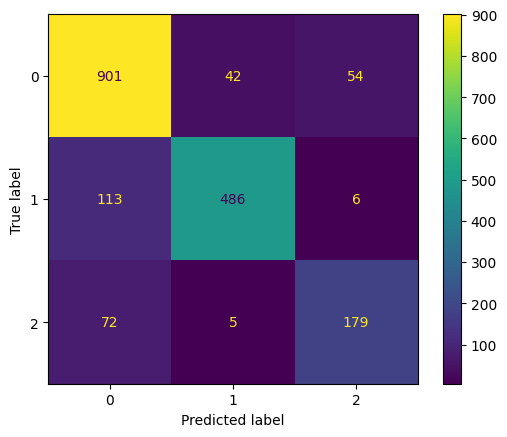

In [24]:
# fined-tuned 
rf_model = RandomForestClassifier(n_estimators=1000,class_weight='balanced',criterion='gini',bootstrap=False,max_features='log2',n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate(y_test,y_pred_rf)